# 라이브러리

In [52]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import re
import joblib

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

# 데이터 불러오기

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')

In [4]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

# 데이터 전처리

## 숫자형 자료

In [5]:
df['apartment_floor_min'] = pd.to_numeric(df['apartment_floor_min'])
df['apartment_floor_max'] = pd.to_numeric(df['apartment_floor_max'])
df['school_students'] = pd.to_numeric(df['school_students'])
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: re.split('\d',x)[0])

In [6]:
print(df.isna().sum())

district_id                0
apartment_id               0
apartment_addr_town        0
apartment_builder          0
apartment_build_year       0
apartment_build_month      0
apartment_floor_min        0
apartment_floor_max        0
apartment_parking          0
apartment_name             0
district_name              0
school_name                0
school_dist                0
school_addr_district       0
school_addr_town           0
school_students          840
st_name                    0
st_dist                    0
st_volume                  0
dtype: int64


- 네이버에서 근처에 학교가 없을 경우, 학교가 없다고 인식하여 결측치가 발생합니다. 이를 0으로 대체하겠습니다.

In [7]:
df['school_students'] = df['school_students'].fillna(0)

### 정규화
- 표준정규분포 정규화

In [8]:
from sklearn.preprocessing import StandardScaler

def standard_scaler(data, variable):
    scaler = StandardScaler()
    scaler.fit(data[variable].values.reshape(-1,1))
    joblib.dump(scaler, f'./model/{variable}_scaler.pkl')

def scaling(data, variable):
    scaler = joblib.load(f'./model/{variable}_scaler.pkl')
    output = scaler.transform(data[variable].values.reshape(-1,1))
    return output

def inverse_scaling(data, variable):
    scaler = joblib.load(f'./model/{variable}_scaler.pkl')
    output = scaler.inverse_transform(data[variable].values.reshape(-1,1))
    return output 

In [9]:
numericals = [
    'apartment_floor_min',
    'apartment_floor_max',
    'apartment_parking',
    'school_students',
    'st_dist',
    'st_volume'
    ]

for variable in numericals:
    standard_scaler(df, variable)
    df[variable] = scaling(df, variable)

## 범주형 자료

In [10]:
labels = [
    'apartment_addr_town',
    'apartment_builder',
    'school_name',
    'school_addr_town',
    'st_name'
    ]

categoricals = [
    'district_id',
    'apartment_addr_town',
    'apartment_builder',
    'apartment_build_year',
    'apartment_build_month',
    'school_name',
    'school_addr_district',
    'school_addr_town',
    'st_name'
    ]

In [11]:
def label_encoding(data, variable):
    encoder = joblib.load(f'./model/{variable}_encoder.pkl')
    output = encoder.transform(data[variable])
    return output

def label_decoding(data, variable):
    encoder = joblib.load(f'./model/{variable}_encoder.pkl')
    output = encoder.inverse_transform(data[variable])
    return output

In [12]:
for variable in labels:
    df[variable] = label_encoding(df, variable)

# Modeling 

## K-Prototypes Clustering

In [13]:
train = df[categoricals + numericals].copy()
print(len(categoricals))

9


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 0 to 8015
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_id            8016 non-null   int64  
 1   apartment_addr_town    8016 non-null   int32  
 2   apartment_builder      8016 non-null   int32  
 3   apartment_build_year   8016 non-null   int64  
 4   apartment_build_month  8016 non-null   int64  
 5   school_name            8016 non-null   int32  
 6   school_addr_district   8016 non-null   int64  
 7   school_addr_town       8016 non-null   int32  
 8   st_name                8016 non-null   int32  
 9   apartment_floor_min    8016 non-null   float64
 10  apartment_floor_max    8016 non-null   float64
 11  apartment_parking      8016 non-null   float64
 12  school_students        8016 non-null   float64
 13  st_dist                8016 non-null   float64
 14  st_volume              8016 non-null   float64
dtypes: f

In [15]:
n_pseudo = range(1,21) 
cost = []
for i in tqdm(n_pseudo):
    kproto = KPrototypes(n_clusters=i, verbose=0, random_state=0, n_jobs=-1)
    kproto.fit_predict(train, categorical=list(range(len(categoricals))))
    cost.append(kproto.cost_)
cost_table = pd.DataFrame({'n':n_pseudo, 'cost':cost})

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [09:15<00:00, 27.78s/it]


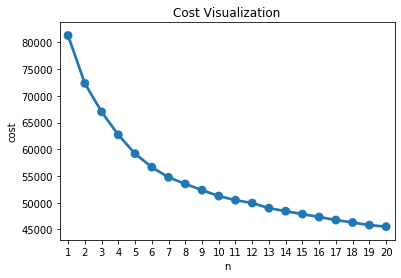

In [16]:
def cost_visualize(data, x, y):
    sns.pointplot(data=data, x=x, y=y)
    plt.title('Cost Visualization')
    plt.show()
cost_visualize(cost_table, 'n', 'cost')

- 적당한 k를 찾기 위해 Elbow Method를 사용합니다. Cost가 줄어드는 비율이 확연하게 줄어드는 지점이 유의미한 k라고 가정합니다. 위의 Cost 시각화 그래프에서 기울기의 절대값이 변동하는 비율이 0.1 이하로 떨어지며 클러스터 수가 작은 값을 적당한 k라고 정의하겠습니다.

In [38]:
cost_table['coef'] = abs(cost_table['cost'] - cost_table['cost'].shift(1))
cost_table['ratio'] =  abs((cost_table['coef'].shift(1) - cost_table['coef'])/cost_table['coef'])
optimal_k = cost_table.loc[cost_table['ratio'] <= 0.1]['n'].min()
print(f'가장 적당한 k는 {optimal_k}입니다.')

가장 적당한 k는 9입니다.


In [39]:
kproto = KPrototypes(n_clusters=optimal_k, verbose=0, random_state=0, n_jobs=-1)
train['cluster'] = kproto.fit_predict(train, categorical=list(range(len(categoricals))))
#joblib.dump(kproto, './model/kprototype_model.pkl')

['./model/kprototype_model.pkl']

## Decoding Into Original

In [40]:
train['apartment_id'] = df['apartment_id']
train['aparmtent_name'] = df['apartment_name']
train['district_name'] = df['district_name']

for variable in numericals:
    train[variable] = inverse_scaling(train, variable)
for variable in labels:
    train[variable] = label_decoding(train, variable)  

In [ ]:
#train.to_pickle('./data/clustered_apartment.pkl')